## ICDAR 2015 exploration

In [20]:
import os
from os import listdir
from os.path import isfile, join
import random

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import numpy as np
from scipy.io import loadmat
%matplotlib inline

### Load data

In [2]:
imgs_dir = r"../total-text/Images/Test"
polygon_labels_dir = r"../total-text/Groundtruth/Polygon/Test"
rectangular_labels_dir = r"../total-text/Groundtruth/Rectangular/Test"

In [3]:
pol_labels_files = [f for f in listdir(polygon_labels_dir) if isfile(join(polygon_labels_dir, f))]
print(f"labels files count: {len(pol_labels_files)}")

labels files count: 300


In [4]:
rec_labels_files = [f for f in listdir(rectangular_labels_dir) if isfile(join(rectangular_labels_dir, f))]
print(f"labels files count: {len(rec_labels_files)}")

labels files count: 300


In [5]:
images_files= [f for f in listdir(imgs_dir) if isfile(join(imgs_dir, f))]
print(f"images files count: {len(images_files)}")
print(f"First 3 images files: {images_files[:3]}")

images files count: 300
First 3 images files: ['img657.jpg', 'img643.jpg', 'img496.jpg']


### Plot random images

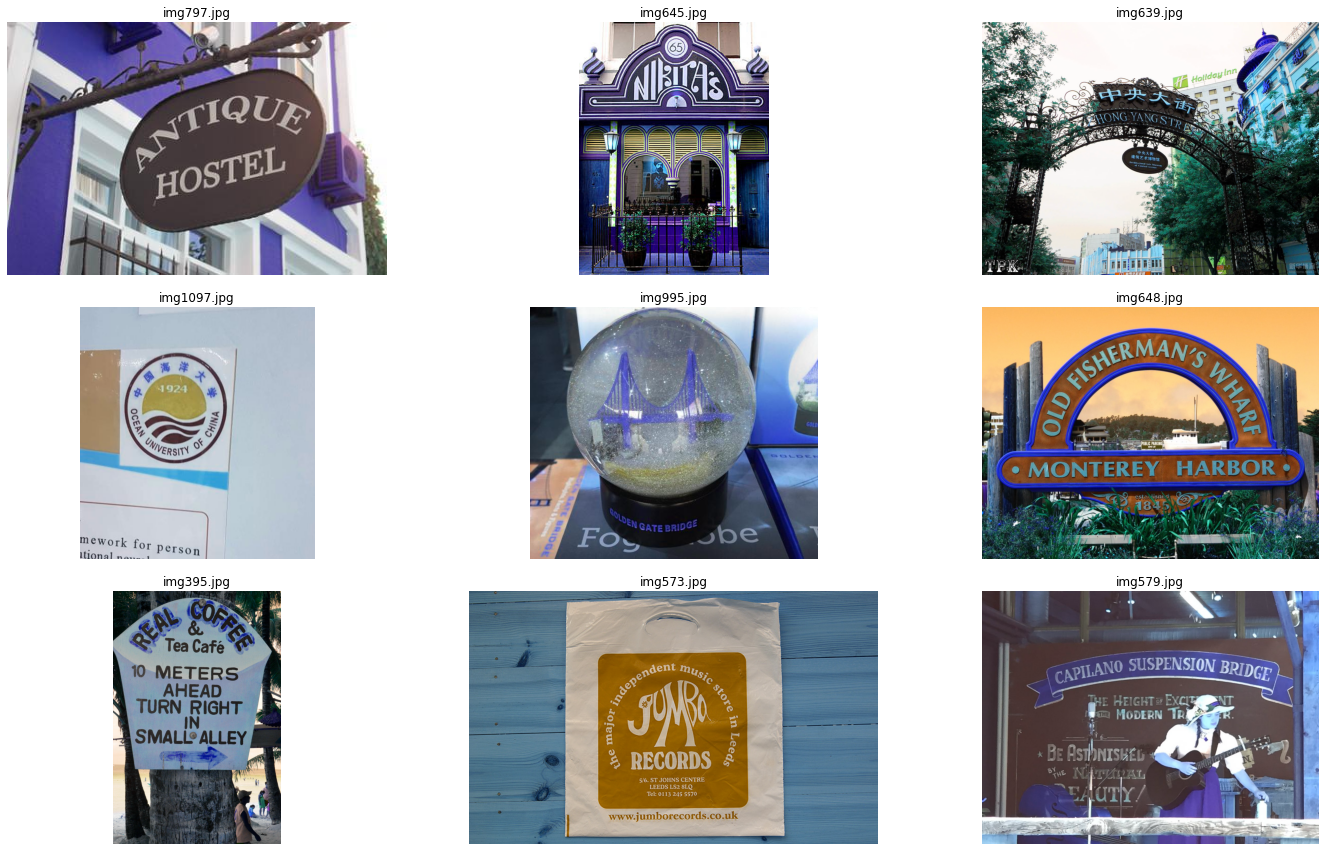

In [6]:
images_to_plot = random.sample(images_files, 9)

fig, axs = plt.subplots(3, 3, figsize=(20, 12))
plt.tight_layout()
axs = axs.flatten()
for img_name, ax in zip(images_to_plot, axs):
    
    img = cv2.imread(os.path.join(imgs_dir, img_name))
    ax.imshow(img)
    ax.set_title(img_name)
    ax.axis('off')

plt.show()

### Plot image with annotations

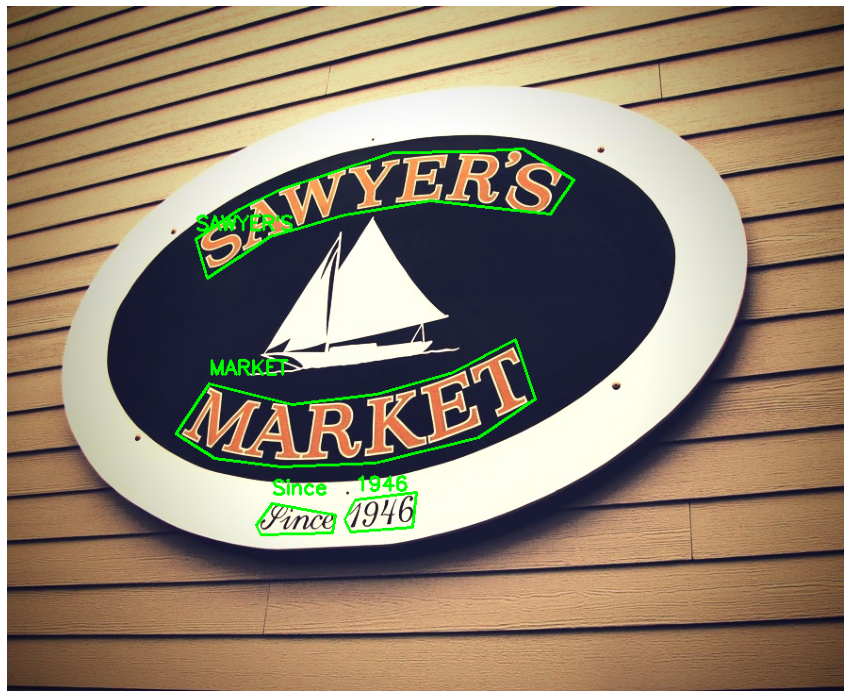

In [17]:
image_number = 641

annotations = loadmat(os.path.join(polygon_labels_dir, f'poly_gt_img{image_number}.mat'))

annots = []
for annot in annotations['polygt']:
    x_coords = annot[1].reshape(-1)
    y_coords = annot[3].reshape(-1)
    annot_dict = {}
    annot_dict['points'] = np.array([(x, y) for x, y in zip(x_coords, y_coords)], dtype="int64").reshape((-1,1,2))
    annot_dict['label'] = annot[-2][0]
    annots.append(annot_dict)
    
# Plot image with annotations
fig, ax = plt.subplots( figsize=(15, 15))
img = cv2.imread(os.path.join(imgs_dir, f'img{image_number}.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
for text in annots:
    if text['label'] != "#":
        color = (0, 255, 0)
    else:
        color = (255, 0, 0)
    cv2.polylines(img,[text['points']],True,color, 2)
    cv2.putText(img, text['label'], (text['points'][0][0][0], text['points'][0][0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
ax.axis('off')
ax.imshow(img);

In [16]:
img.shape

(726, 888, 3)

### Calculate dataset statistics

In [19]:
dataset_stats = {}

for file in rec_labels_files:
    annotations = loadmat(os.path.join(rectangular_labels_dir, file))
    annotations = annotations['rectgt']

    dataset_stats[file] = {}
    dataset_stats[file]['annots_number'] = len(annotations)
        
    for i, annot in enumerate(annotations):
        print(annot)
        dataset_stats[file][i] = {}
        dataset_stats[file][i]['text'] = annot[-2][0] if annot[-2][0] != '#' else ""
        dataset_stats[file][i]['text_len'] = len(annot[-2][0]) if annot[-2][0] != '#' else -1

        dataset_stats[file][i]['width'] = int(annot[4])
        dataset_stats[file][i]['hight'] = int(annot[5])
        print(dataset_stats)
    break

[array([[211]], dtype=int16) array([[254]], dtype=int16)
 array([[313]], dtype=int16) array([[351]], dtype=int16)
 array([[102]], dtype=int16) array([[97]], dtype=int16)
 array(['perrier'], dtype='<U7') array(['c'], dtype='<U1')]
{'rect_gt_img1199.mat': {'annots_number': 1, 0: {'text': 'perrier', 'text_len': 7, 'width': 102, 'hight': 97}}}


In [10]:
dataset_stats[f'rect_gt_img{image_number}.mat']

{'annots_number': 4,
 0: {'text': "SAWYER'S", 'text_len': 8, 'width': 401, 'hight': 137},
 1: {'text': 'MARKET', 'text_len': 6, 'width': 381, 'hight': 135},
 2: {'text': 'Since', 'text_len': 5, 'width': 84, 'hight': 33},
 3: {'text': '1946', 'text_len': 4, 'width': 76, 'hight': 42}}

### Annotations count distribution

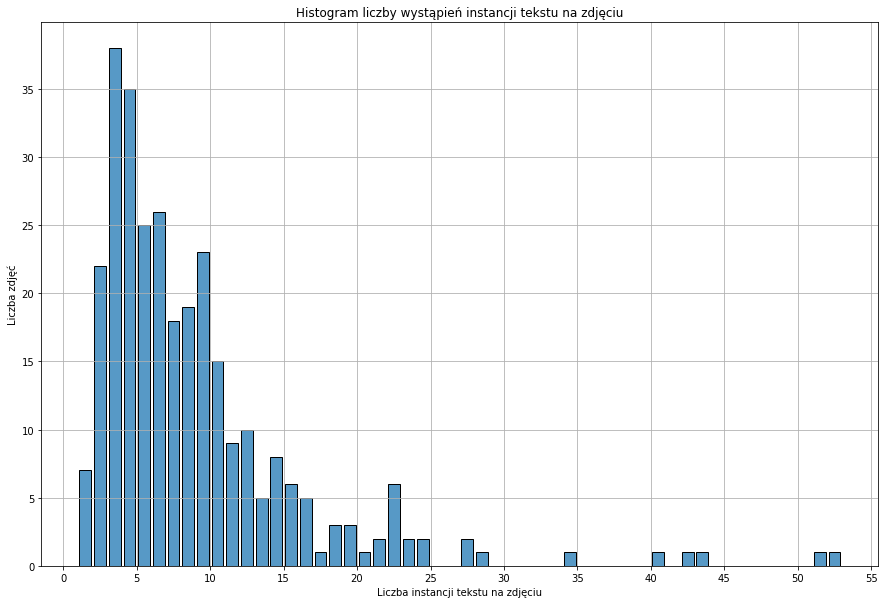

In [11]:
fig, ax = plt.subplots( figsize=(15, 10))

annotation_count = [stats['annots_number'] for stats in dataset_stats.values()]
sns.histplot(annotation_count, ax=ax, binwidth=1, shrink=.8)
# ax.hist(annotation_count, bins=100);
ax.set_xlabel("Liczba instancji tekstu na zdjęciu")
ax.set_ylabel("Liczba zdjęć")
ax.set_title("Histogram liczby wystąpień instancji tekstu na zdjęciu")
ax.set_xticks(np.arange(0, 60, 5))
ax.set_yticks(np.arange(0, 40, 5))
ax.grid()

### Text instances length distribution

In [12]:
instance_without_annotation = [stats['text_len'] for image in dataset_stats.values() for stats in image.values() 
                               if isinstance(stats, dict) and stats['text'] == ""]
instances_all = [stats['text_len'] for image in dataset_stats.values() for stats in image.values() 
                               if isinstance(stats, dict)]
print(f"There are {len(instances_all)} text instances in total.")
print(f"{len(instance_without_annotation)} of them don't have annotation.")

There are 2548 text instances in total.
333 of them don't have annotation.


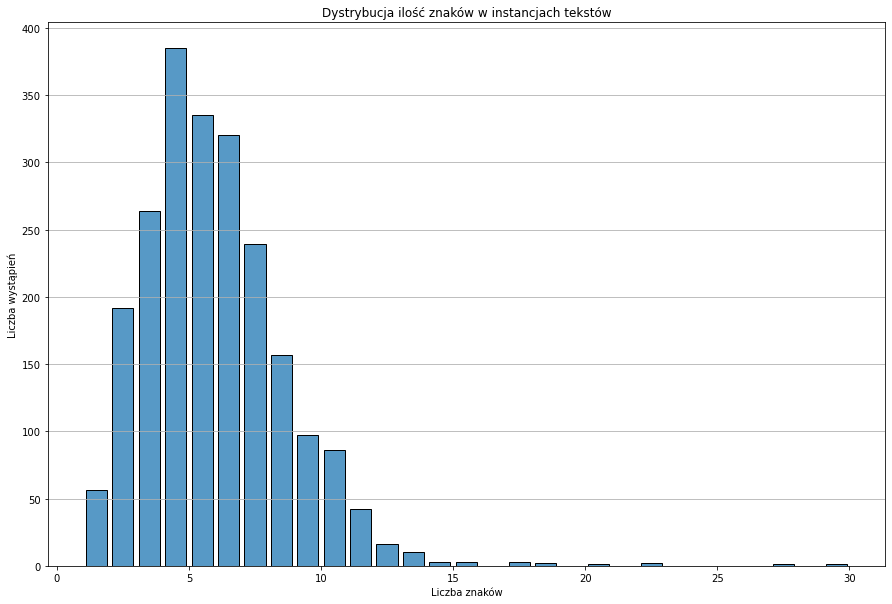

In [13]:
fig, ax = plt.subplots( figsize=(15, 10))

text_length = [stats['text_len'] for image in dataset_stats.values() for stats in image.values() 
               if isinstance(stats, dict) and stats['text'] != ""]

sns.histplot(text_length, ax=ax, binwidth=1, shrink=.8)

ax.set_xlabel("Liczba znaków")
ax.set_ylabel("Liczba wystąpień")
ax.set_title("Dystrybucja ilość znaków w instancjach tekstów")

ax.grid(axis='y');

### Text instances width and hight

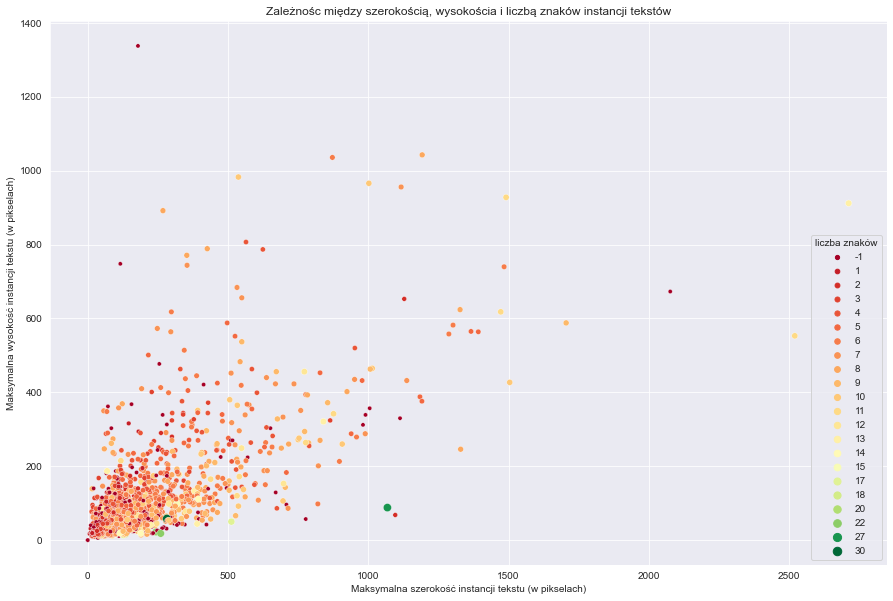

In [14]:
sns.set_style('dark')
fig, ax = plt.subplots( figsize=(15, 10))

text_length = []
text_width = []
text_hight = []

for image in dataset_stats.values():
    for stats in image.values():
        if isinstance(stats, dict):
            text_length.append(stats['text_len'])
            text_width.append(stats['width'])
            text_hight.append(stats['hight'])

df = pd.DataFrame.from_dict({
    'szerokosc': text_width,
    'wysokosc': text_hight,
    'liczba znaków': text_length,
})

sns.scatterplot(x='szerokosc', y='wysokosc', hue='liczba znaków', size='liczba znaków',data=df, palette="RdYlGn", legend='full')

ax.set_xlabel("Maksymalna szerokość instancji tekstu (w pikselach)")
ax.set_ylabel("Maksymalna wysokość instancji tekstu (w pikselach)")

ax.set_title("Zależnośc między szerokością, wysokościa i liczbą znaków instancji tekstów")
ax.grid();


In [15]:
# Save basic ICDAR2015 stats
df.to_csv("Total-text_stats.csv", index=False)